In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [2]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

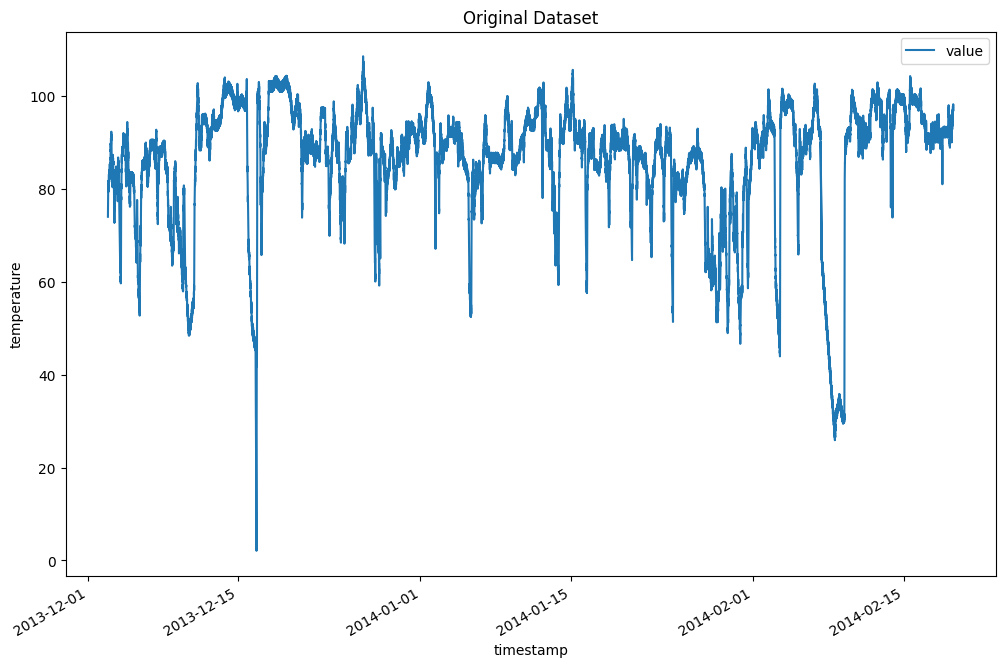

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [4]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [5]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [6]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [8]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [9]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [10]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [11]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [12]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data.columns

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'month_0', 'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')

In [14]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'month_0', 'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [15]:
# Splitting to train and test
test_ratio = 0.3
tr_data = data.iloc[int(len(data) * 0.25): int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [16]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [17]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [18]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
5673,-0.072863,1,0.284115,-1.392295,-1.732601,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5674,0.028166,1,0.296123,-1.392295,-1.732261,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5675,-0.253039,1,0.308131,-1.392295,-1.731921,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5676,-0.233108,1,0.320138,-1.392295,-1.731582,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5677,-0.119571,1,0.332146,-1.392295,-1.731242,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.099055,1,1.677012,1.841695,1.731745,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.089198,1,1.689020,1.841695,1.732085,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.117255,1,1.701027,1.841695,1.732425,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.004729,1,1.713035,1.841695,1.732765,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [19]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
15886,0.100616,1,-1.721176,1.957195,1.733444,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15887,-0.136284,1,-1.709168,1.957195,1.733784,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15888,0.043977,1,-1.697160,1.957195,1.734124,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15889,0.095345,1,-1.685153,1.957195,1.734464,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15890,-0.061215,1,-1.673145,1.957195,1.734803,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.382210,1,0.440216,4.613686,4.045274,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,1.331855,1,0.452223,4.613686,4.045613,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,1.243532,1,0.464231,4.613686,4.045953,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,1.365229,1,0.476239,4.613686,4.046293,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [20]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,day_5,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
5673,-0.072863,0.284115,-1.392295,-1.732601,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5674,0.028166,0.296123,-1.392295,-1.732261,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5675,-0.253039,0.308131,-1.392295,-1.731921,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5676,-0.233108,0.320138,-1.392295,-1.731582,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5677,-0.119571,0.332146,-1.392295,-1.731242,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.099055,1.677012,1.841695,1.731745,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.089198,1.689020,1.841695,1.732085,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.117255,1.701027,1.841695,1.732425,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.004729,1.713035,1.841695,1.732765,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [21]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [22]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [23]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [24]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [25]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var, beta = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + beta*kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [26]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
beta = 0.05

In [27]:
print(input_shape)

(47,)


In [28]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 47)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 23)                   1104      ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 15)                   360       ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 15)                   360       ['dense[0][0]']               
                                                                                            

In [29]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 15)]              0         
                                                                 
 dense_1 (Dense)             (None, 23)                368       
                                                                 
 dense_2 (Dense)             (None, 47)                1128      
                                                                 
Total params: 1496 (5.84 KB)
Trainable params: 1496 (5.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var, beta])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

NameError: name 'Input' is not defined

In [31]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=100,
                        batch_size=128)

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 47)]                 0         []                            
                                                                                                  
 encoder (Functional)        (None, 15)                   1824      ['encoder_input[0][0]']       
                                                                                                  
 dense_3 (Dense)             (None, 23)                   1104      ['encoder_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 47)                   1496      ['encoder[0][0]']             
                                                                                            

80/80 [==============================] - 2s 2ms/step - loss: 2088.8252 - decoder_loss: 0.4999 - vae_loss_layer_loss: 0.0851
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 1973.3849 - decoder_loss: 0.4809 - vae_loss_layer_loss: 0.0851
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 1859.6727 - decoder_loss: 0.4596 - vae_loss_layer_loss: 0.0851
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 1747.2306 - decoder_loss: 0.4362 - vae_loss_layer_loss: 0.0851
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 1627.9861 - decoder_loss: 0.4084 - vae_loss_layer_loss: 0.0851
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 1500.8480 - decoder_loss: 0.3760 - vae_loss_layer_loss: 0.0851
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: 1365.6167 - decoder_loss: 0.3376 - vae_loss_layer_loss: 0.0851
Epoch 8/100
80/80 [==============================] - 0s 1ms/

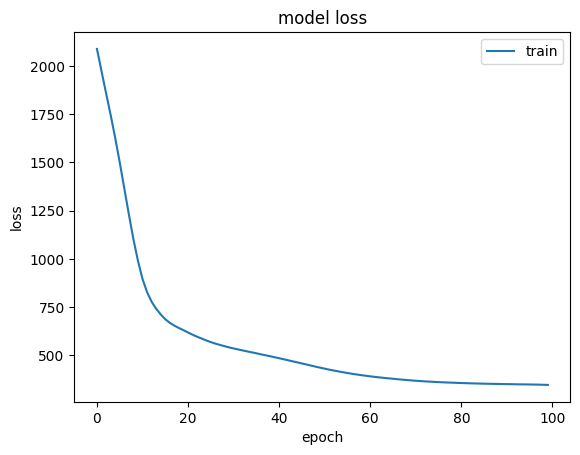

In [32]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [33]:
train_pred = vae_model.predict(train)[0]

320/320 [==============================] - 1s 1ms/step


In [34]:
mae_vector = get_error_term(train_pred, train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.05802815407514572
median error 0.05461253598332405
99Q: 0.13612670958042106
setting threshold on 0.13612670958042106 


In [35]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.1665442796299016


In [36]:
pred = vae_model.predict(test)[0]
mae_vector = get_error_term(pred, test, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

 68/213 [========>.....................] - ETA: 0s

213/213 [==============================] - 0s 2ms/step
Avg error 0.23959815502166748
median error 0.24531598389148712
99Q: 0.3901588356494904


0.9505066823322074

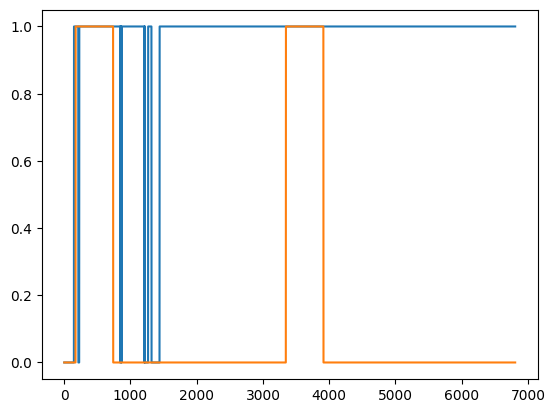

In [37]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [38]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.96      0.06      0.11      5675
        True       0.17      0.99      0.29      1134

    accuracy                           0.21      6809
   macro avg       0.57      0.52      0.20      6809
weighted avg       0.83      0.21      0.14      6809



In [39]:
encoded = encoder.predict(test)

 64/213 [========>.....................] - ETA: 0s 

213/213 [==============================] - 0s 1ms/step


In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(encoded)

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

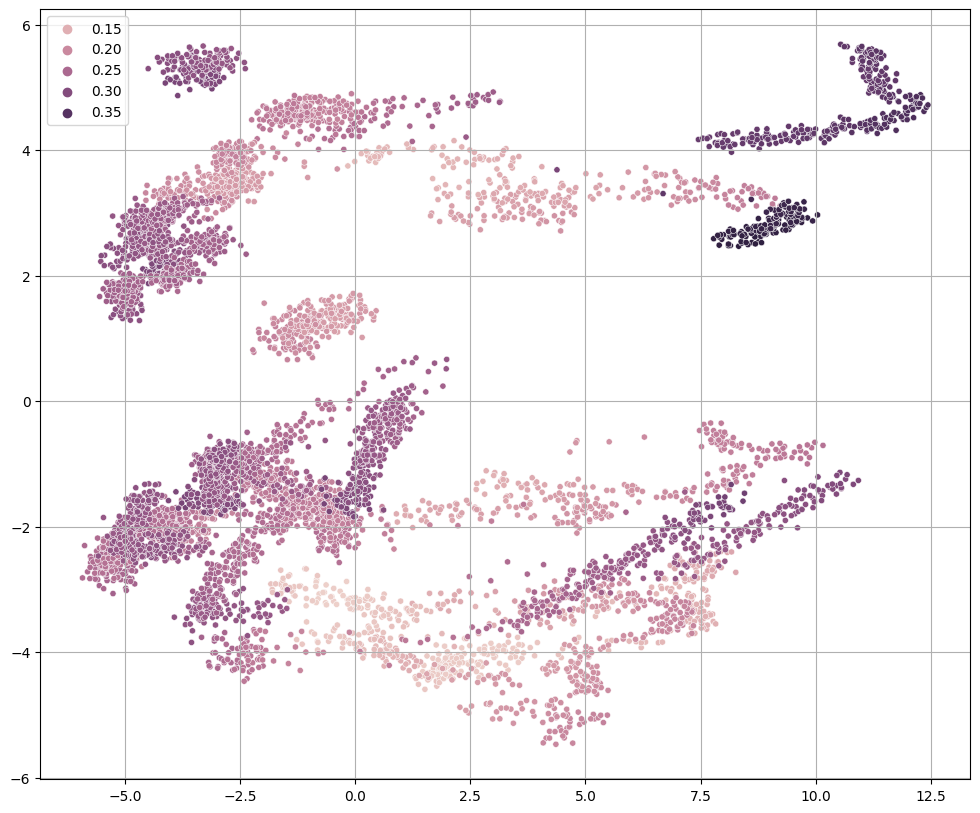

In [41]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

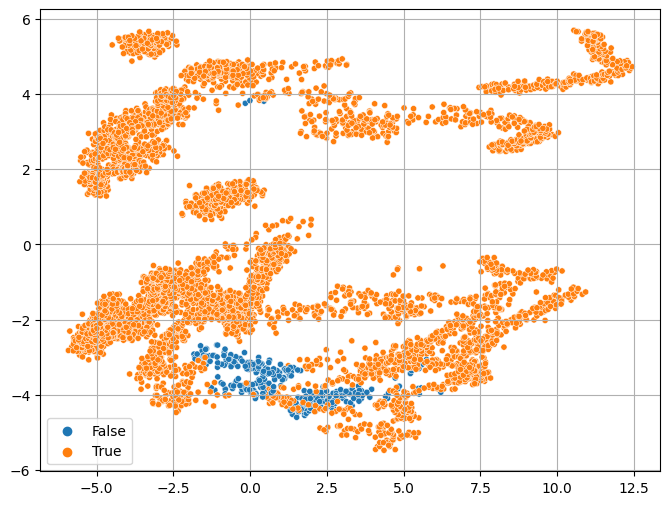

In [42]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

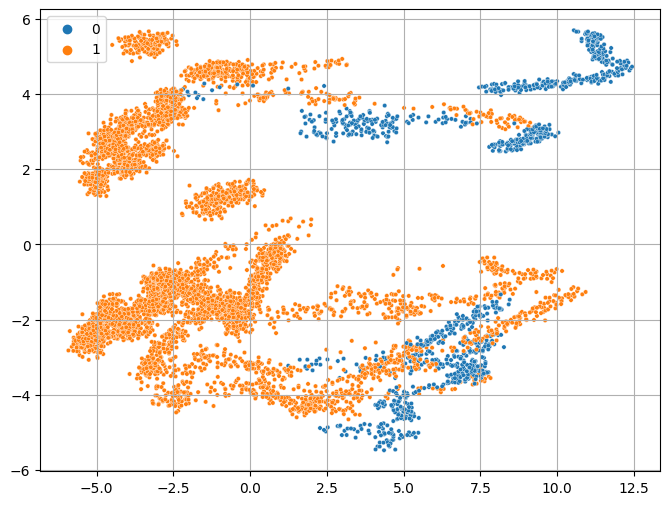

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=10, hue=labels_of_test)
plt.grid()
plt.show()

In [44]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]
tst_data

C:\Users\nickf\AppData\Local\Temp\ipykernel_24508\2082240037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\nickf\AppData\Local\Temp\ipykernel_24508\2082240037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


,timestamp,value,label,anomaly
15886,2014-01-27 00:05:00,88.482330,1,False
15887,2014-01-27 00:10:00,86.688731,1,False
15888,2014-01-27 00:15:00,88.053503,1,False
15889,2014-01-27 00:20:00,88.442419,1,False
15890,2014-01-27 00:25:00,87.257083,1,False
...,...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1,True
22691,2014-02-19 15:10:00,97.804168,1,True
22692,2014-02-19 15:15:00,97.135468,1,True
22693,2014-02-19 15:20:00,98.056852,1,True


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

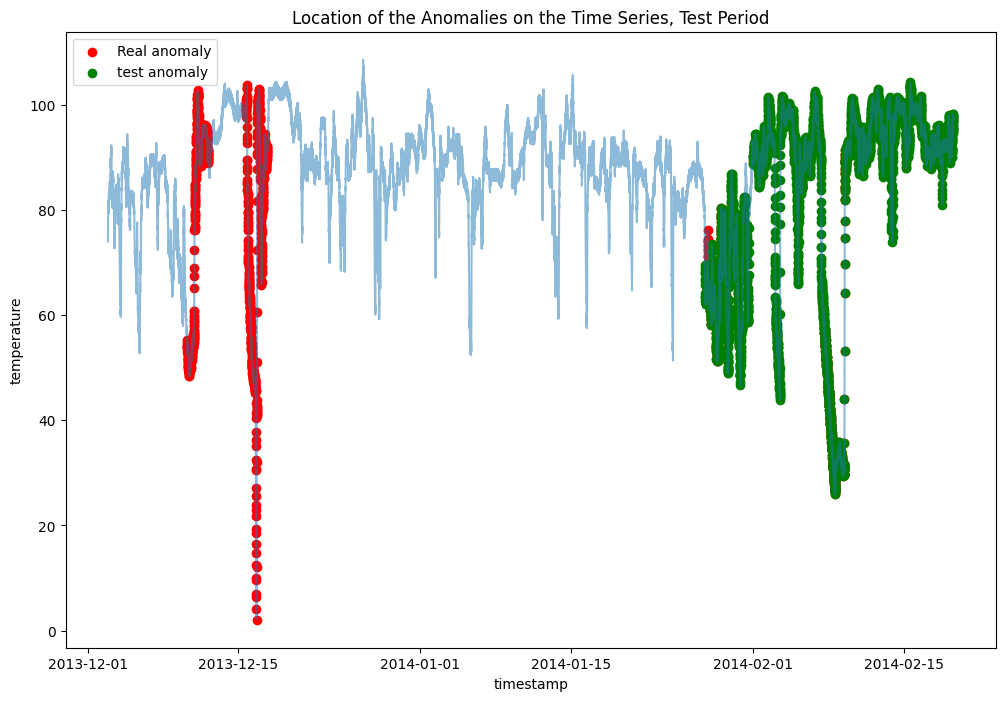

In [45]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], alpha=.5)
ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')

ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")